<a href="https://colab.research.google.com/github/uppalapati-prapadhya/Restaurant-reviews/blob/master/detect_hate_speech_in_tweet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import warnings

In [2]:
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
%matplotlib inline

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [6]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [7]:
combi = pd.concat([train, test], ignore_index=True)



In [8]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)
  return input_txt

In [9]:
#to remove twitter handles (@user)
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")

In [10]:
#to remove special characters, numbers, punctuations
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [11]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [12]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit can't cause they don't off...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time urð±!!! ððð...
4,5,0.0,factsguide: society now #motivation,factsguide: society #motivation


In [13]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, can't, cause, they, do...
2                              [bihday, your, majesty]
3    [#model, love, take, with, time, urð±!!!, ð...
4                  [factsguide:, society, #motivation]
Name: tidy_tweet, dtype: object

In [14]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, can't, caus, they, don'...
2                              [bihday, your, majesti]
3    [#model, love, take, with, time, urð±!!!, ð...
4                       [factsguide:, societi, #motiv]
Name: tidy_tweet, dtype: object

In [15]:
for i in range(len(tokenized_tweet)):
  tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
combi['tedy_tweet'] = tokenized_tweet

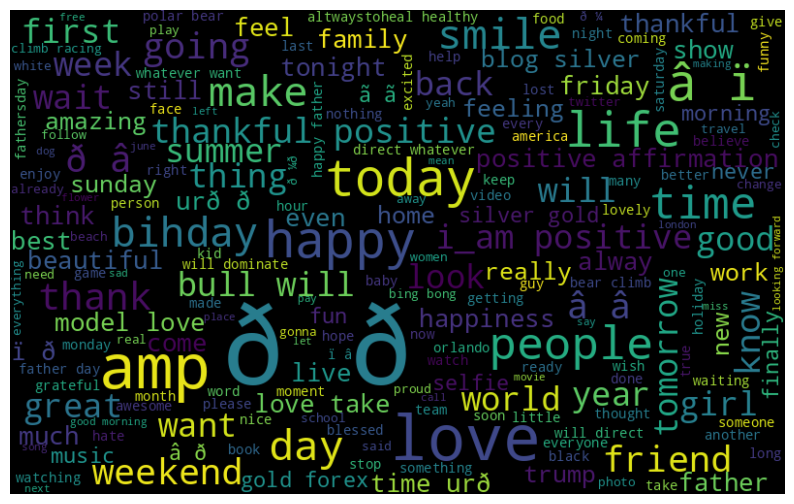

In [16]:
all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

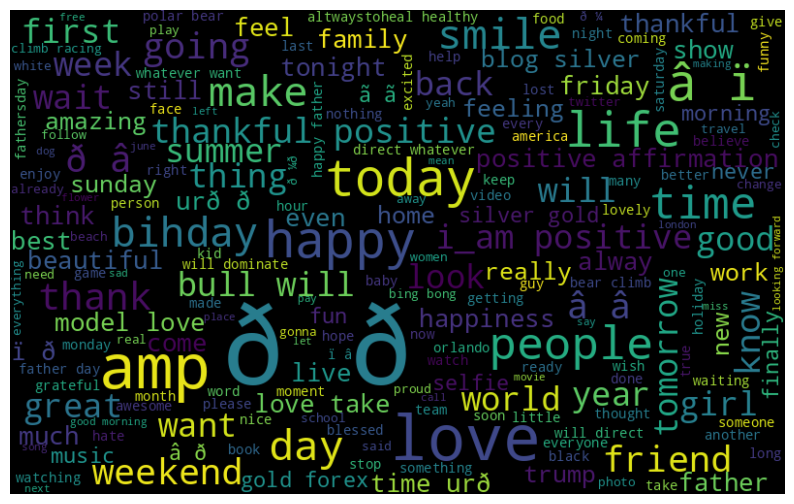

In [17]:
normal_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

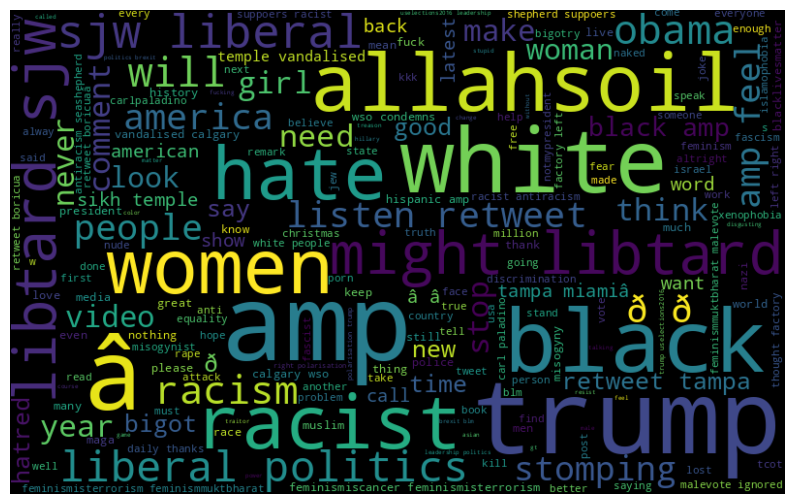

In [18]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
                      random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [19]:
def hashtag_extract(x):
  hashtags = []
  for i in x:
    ht = re.findall(r"#(\w+)", i)
    hashtags.append(ht)

  return hashtags

In [20]:
# extracting hashtags from non racist/sexist tweets
HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])
# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label']== 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative, [])


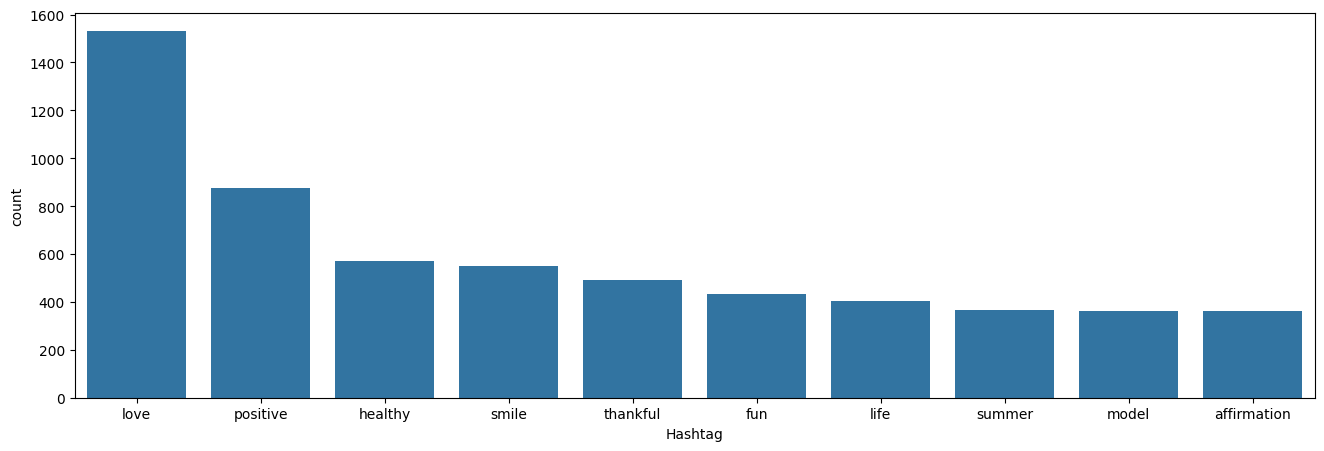

In [21]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag' : list(a.keys()),
                  'Count': list(a.values())})
#selecting top 10 most frequent hashtags
d = d.nlargest(columns="Count", n = 10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'count')
plt.show()

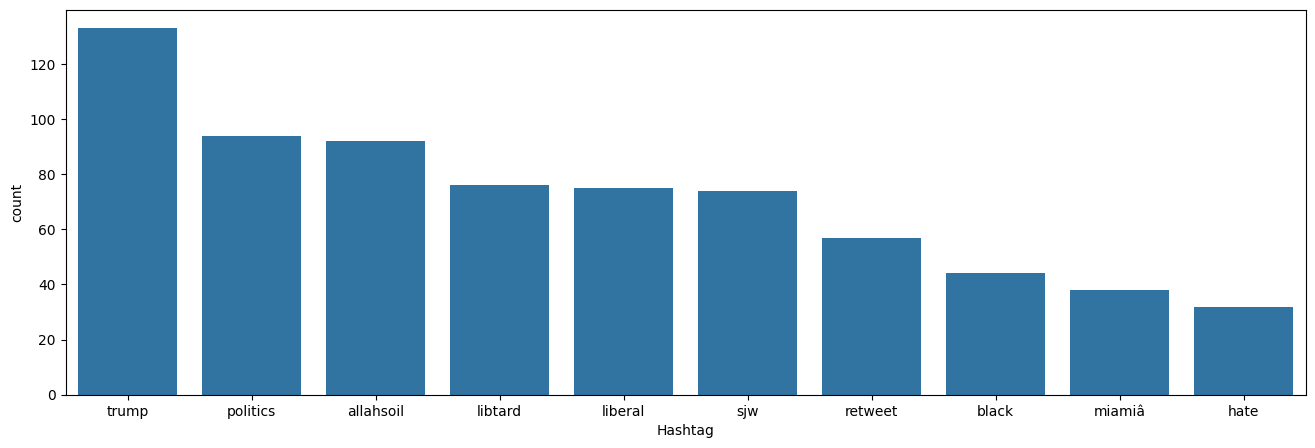

In [22]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag' : list(b.keys()),
                  'Count': list(b.values())})
#selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'count')
plt.show()

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000,stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np

train_bow = bow[:31962, :]
test_bow = bow[31962:, :]

# Splitting the data into training and validation sets
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.2)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain)

prediction = lreg.predict_proba(xvalid_bow)
prediction_int = (prediction[:, 1] >= 0.3).astype(int)

f1_score(yvalid, prediction_int)



0.5426751592356687

In [30]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:, 1] >= 0.3
test_pred_int = test_pred_int.astype(int)
test['label'] = test_pred_int
submission = test[['id', 'label']]
submission.to_csv('sub_lreg_bow.csv', index=False)


In [34]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(int)
f1_score(yvalid, prediction_int)

0.5395590142671854